# Lennart Vetter, Wongee Hong, Myisha Hassan

**Assignment 7: Gibbs Sampling**

Read the paper on Gibbs sampling, implement it using a software package such as PyMC, Stan, PyStan. Note that Gibbs sampling itself doesn't cooperate with some of these packages for this particular scenario. Use any sampling method available to do the inference.

Stretch goal 5 points: Implement Gibbs sampling by hand as shown in the paper.

# Implementing Gibbs Sampling with Software Packages

True parameters:
  lambda1 = 2.0, lambda2 = 8.0, n = 26
First 10 observations: [1 1 2 3 2 3 2 1 1 0]


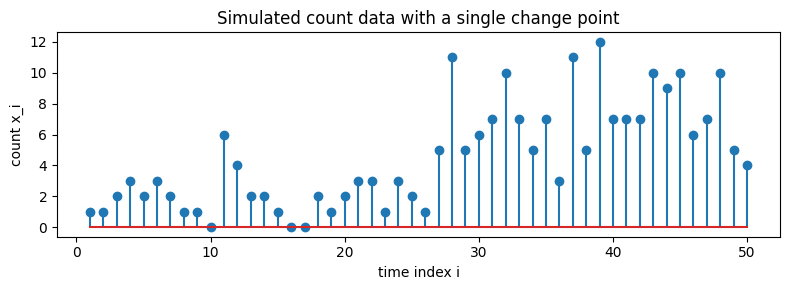

Output()


PyMC posterior summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda1   1.914  0.275   1.397    2.418      0.003    0.003    8755.0   
lambda2   7.132  0.527   6.175    8.146      0.006    0.005    9085.0   
tau      26.212  0.442  26.000   27.000      0.010    0.008    1903.0   

         ess_tail  r_hat  
lambda1    6386.0    1.0  
lambda2    6892.0    1.0  
tau        1786.0    1.0  


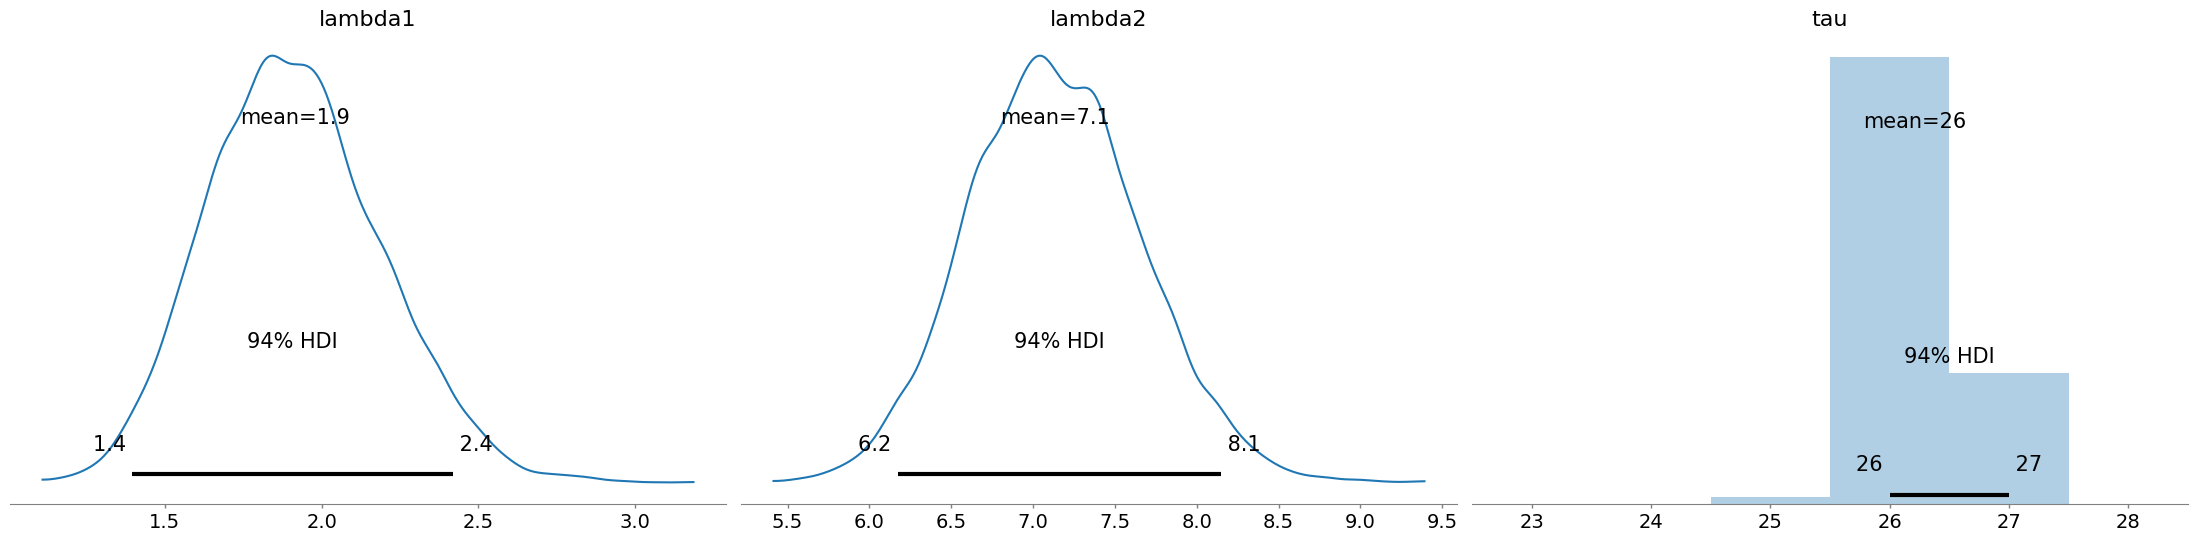

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Data generation

def simulate_changepoint_data(
    N=50,
    true_n=26,
    true_lambda1=2.0,
    true_lambda2=8.0,
    random_seed=123,
):
    """
    Simulate Poisson counts with a single rate change at time true_n.
    Time indices i = 1,...,N; the array indices are 0,...,N-1.
    """
    rng = np.random.default_rng(random_seed)
    x = np.empty(N, dtype=int)

    # First segment: 1..true_n -> indices 0..true_n-1
    x[:true_n] = rng.poisson(true_lambda1, size=true_n)
    # Second segment: true_n+1..N -> indices true_n..N-1
    x[true_n:] = rng.poisson(true_lambda2, size=N - true_n)

    return x, true_n, true_lambda1, true_lambda2


# PyMC model and sampling

def run_pymc_inference(x, a=2.0, b=1.0, draws=5000, tune=2000, random_seed=123):
    """
    Build and fit the change-point model in PyMC.

    x : 1D numpy array of counts (length N).
    tune: Burn in steps.
    a, b : Gamma hyperparameters (shape a, rate b).
    """
    N = len(x)
    idx = np.arange(N)  # 0..N-1, used to build piecewise rate

    with pm.Model() as model:
        # Priors
        lambda1 = pm.Gamma("lambda1", alpha=a, beta=b)
        lambda2 = pm.Gamma("lambda2", alpha=a, beta=b)
        # n is the change point in {1,...,N}; we store as 'tau'
        tau = pm.DiscreteUniform("tau", lower=1, upper=N)

        # piecewise Poisson rate: indices <= tau-1 get lambda1, else lambda2
        # (since tau is 1-based and idx is 0-based)
        rate = pm.math.switch(idx <= (tau - 1), lambda1, lambda2)

        # Likelihood
        obs = pm.Poisson("obs", mu=rate, observed=x)

        # Let PyMC select appropriate samplers (NUTS for continuous, Metropolis for discrete)
        trace = pm.sample(
            draws=draws,
            tune=tune,
            random_seed=random_seed,
            return_inferencedata=True,
            target_accept=0.9,
        )

    return model, trace


def summarize_pymc_results(trace):
    """Print a concise summary of posterior for lambda1, lambda2, and tau."""
    print(az.summary(trace, var_names=["lambda1", "lambda2", "tau"]))


def plot_pymc_posteriors(trace):
    """Make histogram / KDE plots for lambda1, lambda2, tau."""
    az.plot_posterior(trace, var_names=["lambda1", "lambda2", "tau"])
    plt.tight_layout()
    plt.show()

# Run package-based inference

# Simulate synthetic data
x, true_n, true_l1, true_l2 = simulate_changepoint_data()
print("True parameters:")
print(f"  lambda1 = {true_l1}, lambda2 = {true_l2}, n = {true_n}")
print("First 10 observations:", x[:10])

# Optional: plot the data (like in the paper)
plt.figure(figsize=(8, 3))
plt.stem(np.arange(1, len(x) + 1), x)
plt.xlabel("time index i")
plt.ylabel("count x_i")
plt.title("Simulated count data with a single change point")
plt.tight_layout()
plt.show()

# Run PyMC inference
model, trace = run_pymc_inference(x)
print("\nPyMC posterior summary:")
summarize_pymc_results(trace)

# Posterior plots
plot_pymc_posteriors(trace)

# Stretch Goal: Hand-written Gibbs sampler


Gibbs posterior summaries (after burn-in):
  lambda1_mean: 1.9080086967454626
  lambda1_sd: 0.26734727823365795
  lambda2_mean: 7.130451143000383
  lambda2_sd: 0.530988638306377
  n_mean: 26.1878
  n_mode: 26


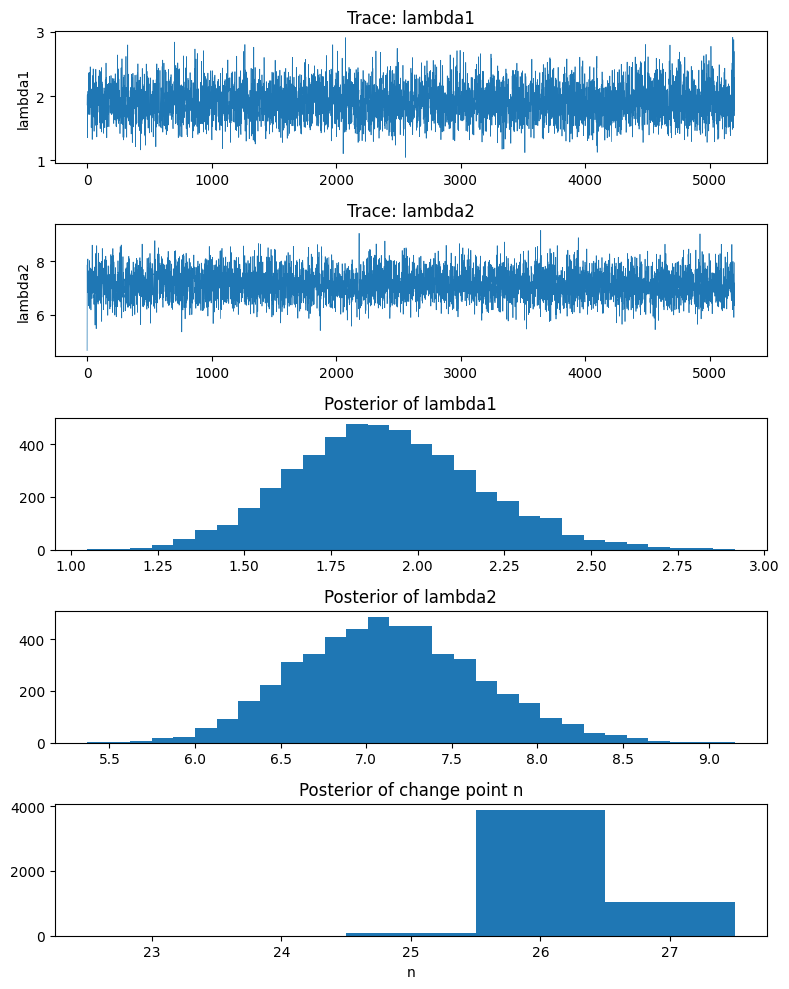

In [ ]:
# reuse: x, true_n, true_l1, true_l2 from eariler cell

def gibbs_changepoint(
    x,
    a=2.0,
    b=1.0,
    num_iters=5200,
    random_seed=123,
):
    """
    Hand-coded Gibbs sampler for the change-point model in the Yildirim note.

    Model:
        n ~ Uniform{1,...,N}
        lambda1 ~ Gamma(a, b)      (shape a, rate b)
        lambda2 ~ Gamma(a, b)      (shape a, rate b)
        x_i | n, lambdas ~ Poisson(lambda1) if i <= n, Poisson(lambda2) if i > n

    Returns:
        lam1_samples, lam2_samples, n_samples (each length num_iters)
    """
    rng = np.random.default_rng(random_seed)
    x = np.asarray(x, dtype=np.int64)
    N = x.size

    # Precompute cumulative sums for efficient n-conditional computation
    cumsum_x = np.cumsum(x)
    total_x = cumsum_x[-1]

    # Storage
    lam1_samples = np.empty(num_iters)
    lam2_samples = np.empty(num_iters)
    n_samples = np.empty(num_iters, dtype=int)

    # ---- Initialization from priors ----
    # n in {1,...,N}
    n = rng.integers(1, N + 1)
    # lambda1, lambda2 ~ Gamma(a, b) with density proportional to
    #   lambda^(a-1) exp(-b lambda)
    # numpy.random.gamma uses shape=a, scale=1/rate
    lam1 = rng.gamma(shape=a, scale=1.0 / b)
    lam2 = rng.gamma(shape=a, scale=1.0 / b)

    for t in range(num_iters):
        # --- Sample lambda1 | others ---
        # S1 = sum_{i=1}^n x_i,  count1 = n
        S1 = cumsum_x[n - 1]  # because n is 1-based, cumsum_x is 0-based
        count1 = n
        shape1 = a + S1
        rate1 = b + count1
        lam1 = rng.gamma(shape=shape1, scale=1.0 / rate1)

        # --- Sample lambda2 | others ---
        # S2 = sum_{i=n+1}^N x_i = total_x - S1,  count2 = N - n
        S2 = total_x - S1
        count2 = N - n
        shape2 = a + S2
        rate2 = b + count2
        lam2 = rng.gamma(shape=shape2, scale=1.0 / rate2)

        # --- Sample n | lambda1, lambda2, x ---
        # log p(n | ...) up to a constant (Equation (10) in the note):
        #   (sum_{i=1}^n x_i) * log(lambda1) - n * lambda1
        # + (sum_{i=n+1}^N x_i) * log(lambda2) - (N - n) * lambda2
        possible_n = np.arange(1, N + 1)
        S1_all = cumsum_x              # S1_all[k-1] = sum_{i=1}^k x_i
        S1_vec = S1_all                # index k-1 corresponds to n=k
        S2_vec = total_x - S1_vec
        count1_vec = possible_n
        count2_vec = N - possible_n

        log_p_n = (
            S1_vec * np.log(lam1)
            - count1_vec * lam1
            + S2_vec * np.log(lam2)
            - count2_vec * lam2
        )

        # stabilize & exponentiate to get probabilities
        log_p_n -= np.max(log_p_n)
        p_n_unnorm = np.exp(log_p_n)
        p_n = p_n_unnorm / p_n_unnorm.sum()

        # Draw new n
        n = rng.choice(possible_n, p=p_n)

        # Store samples
        lam1_samples[t] = lam1
        lam2_samples[t] = lam2
        n_samples[t] = n

    return lam1_samples, lam2_samples, n_samples


def gibbs_posterior_summaries(lam1_samples, lam2_samples, n_samples, burn_in=200):
    """
    Simple numeric summaries from Gibbs output (after burn-in).
    """
    lam1_post = lam1_samples[burn_in:]
    lam2_post = lam2_samples[burn_in:]
    n_post = n_samples[burn_in:]

    summary = {
        "lambda1_mean": float(lam1_post.mean()),
        "lambda1_sd": float(lam1_post.std(ddof=1)),
        "lambda2_mean": float(lam2_post.mean()),
        "lambda2_sd": float(lam2_post.std(ddof=1)),
        "n_mean": float(n_post.mean()),
        "n_mode": int(
            np.bincount(n_post).argmax()
        ),  # most frequent change point in posterior
    }
    return summary


def plot_gibbs_traces(lam1_samples, lam2_samples, n_samples, burn_in=200):
    """
    Trace and histogram plots similar in spirit to the figure in the note.
    """
    lam1_post = lam1_samples[burn_in:]
    lam2_post = lam2_samples[burn_in:]
    n_post = n_samples[burn_in:]

    fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=False)

    # Traces for lambda1 and lambda2
    axes[0].plot(lam1_samples, linewidth=0.5)
    axes[0].set_title("Trace: lambda1")
    axes[0].set_ylabel("lambda1")

    axes[1].plot(lam2_samples, linewidth=0.5)
    axes[1].set_title("Trace: lambda2")
    axes[1].set_ylabel("lambda2")

    # Histograms
    axes[2].hist(lam1_post, bins=30)
    axes[2].set_title("Posterior of lambda1")

    axes[3].hist(lam2_post, bins=30)
    axes[3].set_title("Posterior of lambda2")

    axes[4].hist(n_post, bins=np.arange(n_post.min(), n_post.max() + 2) - 0.5)
    axes[4].set_title("Posterior of change point n")
    axes[4].set_xlabel("n")

    plt.tight_layout()
    plt.show()

# Run hand-written Gibbs sampler

lam1_s, lam2_s, n_s = gibbs_changepoint(x)
gibbs_summary = gibbs_posterior_summaries(lam1_s, lam2_s, n_s)

print("\nGibbs posterior summaries (after burn-in):")
for k, v in gibbs_summary.items():
    print(f"  {k}: {v}")

plot_gibbs_traces(lam1_s, lam2_s, n_s)